# 3D Gaussian Mask Generation Notebook

In [1]:
import sys
sys.dont_write_bytecode = True

import torch 
import numpy as np 
from matplotlib import pyplot as plt
from plyfile import PlyData
from projection.projections import camera_to_image, world_to_camera, filter_pixel_points, get_3D_indices
from util.view import Viewset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Constants

In [2]:
GAUSSIAN_FILE = './projection/point_cloud/iteration_30000/point_cloud.ply' 
CAMERAS_JSON = './projection/cameras.json'
IMAGE_PATH = './dataset/truck/images/'

# sampling radius for mapping 2D prompts to 3D gaussians
EPS = 10

MASK_PADDING = 10 # do not sample initial points from within padding

### Input variables

In [3]:
init_view_count = 4 # randomly sample some views to generate initial prompt points from

prompts_per_view = 2
 
text_prompt = "truck"

# init_view_index = 125

# init_prompts = torch.tensor([[380, 250], [800, 260], [200, 250], [200, 350]]).T

# create masks from a random subset of views if rate < 1
view_sampling_rate = 0.5

***
# 1. Initialization

### Load Gaussians

In [4]:
pcd = PlyData.read(GAUSSIAN_FILE)['vertex']
pcd_array = np.array([pcd['x'], pcd['y'], pcd['z']], dtype=np.double).T
opacities = pcd['opacity']

pcd_array = torch.from_numpy(pcd_array)
opacities = torch.from_numpy(opacities)

In [5]:
# load sam and lang_sam
from sam.sam import SAM
from sam.lang_sam import LangSAM

torch.cuda.empty_cache()

sam = SAM("./sam/sam_vit_h_4b8939.pth")
langsam = LangSAM(sam.predictor)

ModuleNotFoundError: No module named 'groundingdino'

### Load views, select initial views, and 2D prompts

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Cluster Centers:
[[-6.69703248e-01  5.16351115e-02 -5.67947560e-01  5.61416652e-01
  -2.35124198e-01  6.78608631e-01  1.70444526e-01  9.58880498e-01
   1.74913542e-01 -6.98752056e-01  6.21215881e-02  5.96243647e-01]
 [ 7.44089287e-01 -4.96489808e-02  5.33804832e-01 -4.89763439e-01
   6.90925465e-02 -7.12493707e-01 -1.36222802e-01  9.59085758e-01
   2.25387081e-01  7.03075563e-01  2.15491116e-01 -4.57469803e-01]
 [-4.71033971e-01 -1.39415959e-01  7.60844403e-01 -7.74542454e-01
  -1.78931076e-01  4.78067212e-01  4.00246399e-02  9.22502823e-01
   3.65185987e-01 -5.05095572e-01  3.23982553e-01 -7.04586301e-01]
 [ 5.76098815e-01  1.49601195e-01 -7.05371582e-01  8.35549465e-01
   2.05511810e-02 -3.98498542e-01 -1.17757616e-02  9.95025582e-01
   2.45541098e-02  3.99025808e-01  6.79530098e-04  8.34184496e-01]]
Labels:
[3 3 3 0 0 3 0 0 2 2 2 2 2 1 1 1 3 3 0 0 2 2 1 1 3 3 3 0 0 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

c:\Python311\Lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


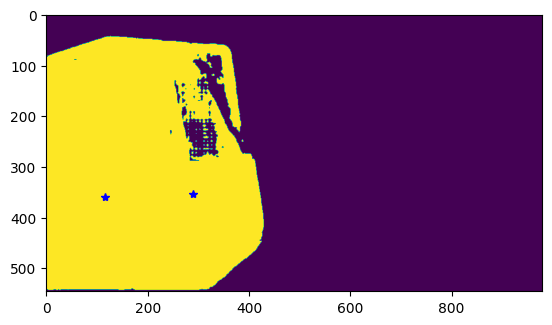

c:\Python311\Lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


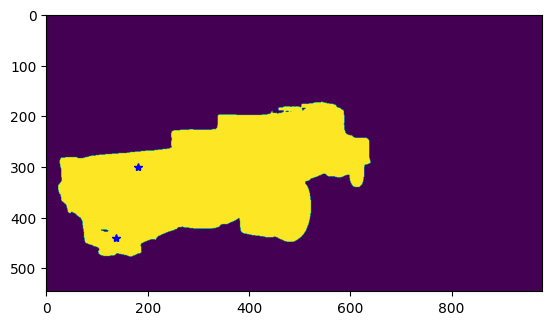

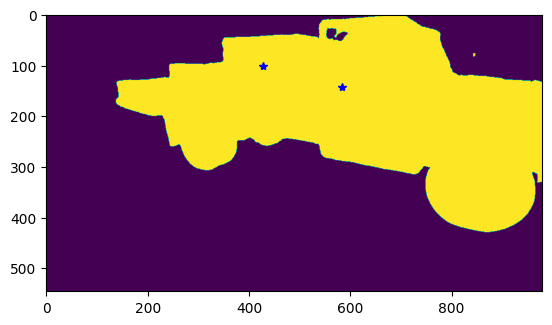

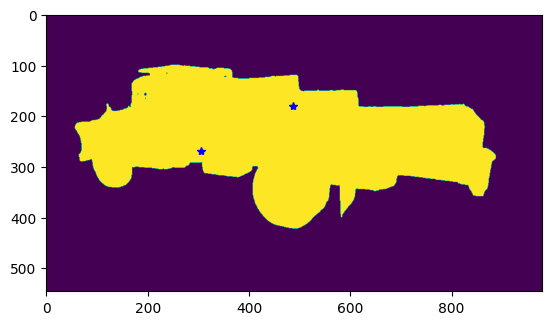

In [ ]:
from sam.util import get_best_mask, shrink_mask, sample_points_from_mask
from PIL import Image

views = Viewset(camera_json=CAMERAS_JSON, dataset_path=IMAGE_PATH)

init_views = views.sample(init_view_count, k_means=True)
init_prompts = [] # tuples of (view, prompt_coords)

for view in init_views:
    masks, boxes, phrases, logits = langsam.predict(Image.fromarray(view.image), text_prompt)
    # plt.plot(init_prompts[0,:], init_prompts[1,:], 'b*')
    mask, logit = get_best_mask(masks, logits)
    # maybe filter out mask with low logits here
    mask_shrunk = shrink_mask(np.uint8(mask.numpy()), MASK_PADDING)
    
    prompts = sample_points_from_mask(mask_shrunk, prompts_per_view).T
    init_prompts.append((view, prompts))
    plt.imshow(mask)
    plt.plot(prompts[0,:], prompts[1,:], 'b*')
    plt.show()

### Map 2D input points to 3D Gaussians

In [ ]:
prompt_gaussians = torch.empty((0, 3))

for view, prompts in init_prompts:

    projection = view.project(pcd_array)

    # scale user points in case image mismatches sizes defined in cameras.json
    user_points = view.scale_from_image(prompts)

    pcd_indices = get_3D_indices(projection.coords, projection.depths, 
                                projection.indices, user_points, EPS, opacities)

    gaussians = pcd_array[pcd_indices, :] 
    prompt_gaussians = torch.vstack((prompt_gaussians, gaussians))

print(prompt_gaussians) 

Point 1: 
	 Depth: 1.1553890081771443
	 (x,y) => tensor([235, 727], dtype=torch.int32)
Point 2: 
	 Depth: 1.4816784928800133
	 (x,y) => tensor([584, 704], dtype=torch.int32)
Point 1: 
	 Depth: 2.2560633126340925
	 (x,y) => tensor([370, 604], dtype=torch.int32)
Point 2: 
	 Depth: 2.3826563821797704
	 (x,y) => tensor([269, 887], dtype=torch.int32)
Point 1: 
	 Depth: 2.6750881810455596
	 (x,y) => tensor([1167,  288], dtype=torch.int32)
Point 2: 
	 Depth: 2.849063899405039
	 (x,y) => tensor([853, 202], dtype=torch.int32)
Point 1: 
	 Depth: 2.507652468952532
	 (x,y) => tensor([980, 362], dtype=torch.int32)
Point 2: 
	 Depth: 3.0625526623060106
	 (x,y) => tensor([617, 532], dtype=torch.int32)
tensor([[-1.2936,  0.2808, -0.2050],
        [-0.9129,  0.4150, -0.1976],
        [ 2.7672,  0.2499,  0.9733],
        [ 2.8343,  0.8815,  0.7866],
        [-0.7046,  0.0195,  1.1392],
        [ 0.0473, -0.1819,  1.3368],
        [ 1.4686,  0.2586, -0.3718],
        [ 0.3752,  0.6524, -0.3722]], dtype=t

***
# 2. Creating Masks from Prompts

Helper function

In [16]:
def predict_mask_from_view(prompt_gaussians, view):
    points, labels = view.project(prompt_gaussians).to_sam_input(view.scale)
    if points.shape[0] == 0:
        # handle cases when none of the prompt gaussians are in view
        return None

    mask_view, scores_view, _ = sam.predict(view.image, points, labels, multimask=True)

    # get mask with the best score
    max_score = 0
    max_ind = 0
    for i, score in enumerate(scores_view):
        if score > max_score:
            max_score = score
            max_ind = i

    return mask_view[max_ind], points

Create Masks from multiple views

Create masks from a subset of all views, based on `view_sampling_rate`. Results are stored in `results`

In [17]:
from tqdm import tqdm

torch.cuda.empty_cache()

views_subset = views.sample(round(view_sampling_rate * views.count))

# results is a list of result sublist each containing [view, mask, prompt_point_pos]
results = []

# track views that do not contain the prompt points
missing_view_indices = []

for view in tqdm(views_subset):
    result = predict_mask_from_view(prompt_gaussians, view)

    if result is not None:
        results.append([view, *result])
    else:
        missing_view_indices.append(view.index)

print("Views containing no visible prompt points:", missing_view_indices)

100%|██████████| 126/126 [05:25<00:00,  2.58s/it]

Views containing no visible prompt points: []


### Optionally save and load serialized results

In [18]:
# save serialized results
import pickle

with open("./results.pkl", "wb") as f:
    pickle.dump(results, f)

In [5]:
import pickle

# load results
with open("./results_multi_text_random.pkl", 'rb') as f:
    results = pickle.load(f)

print(results[0][0]) # view
print(results[0][1]) # mask
print(results[0][2]) # projected prompts

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[ 27. 328.]
 [275. 146.]
 [589. 216.]
 [231. 222.]]


### Visualize all result masks

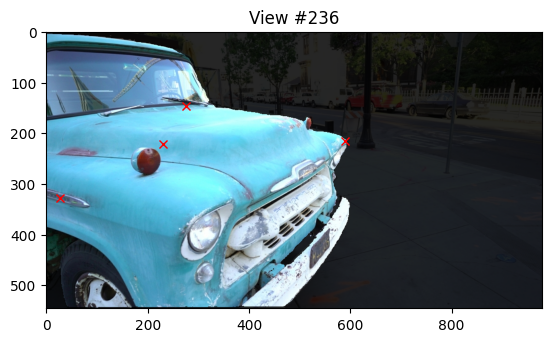

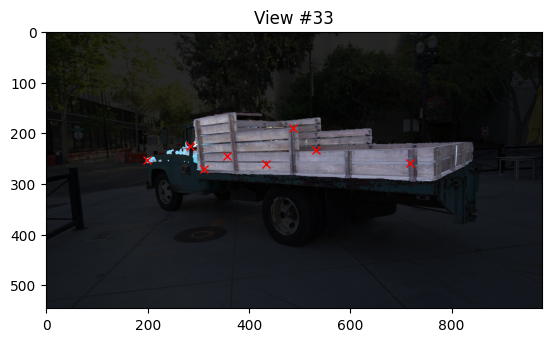

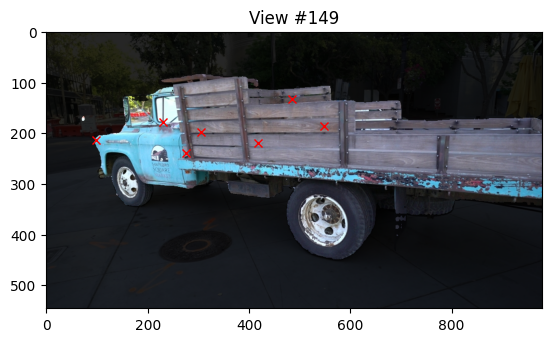

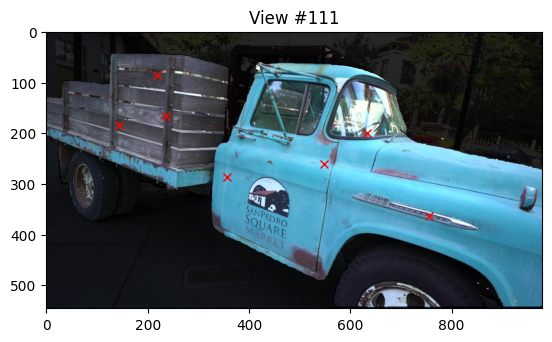

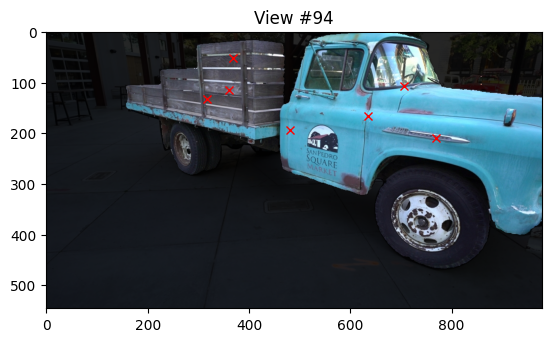

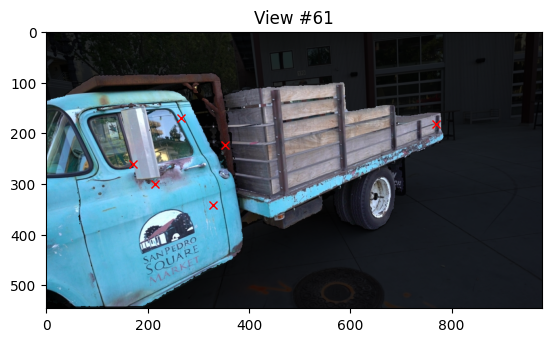

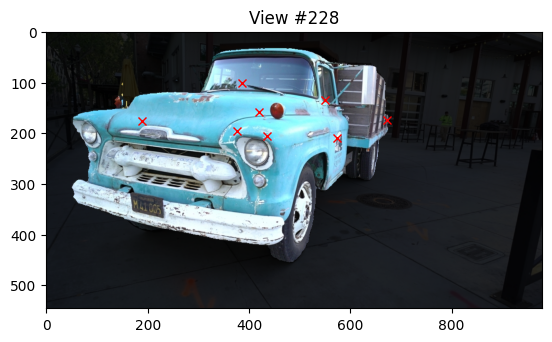

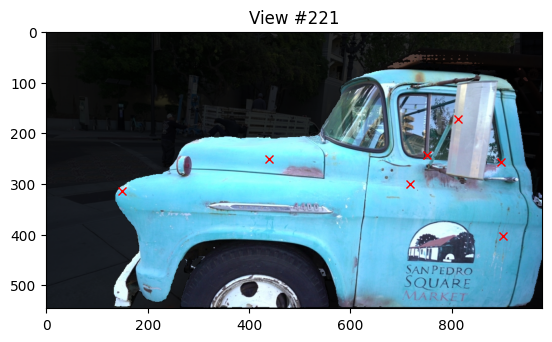

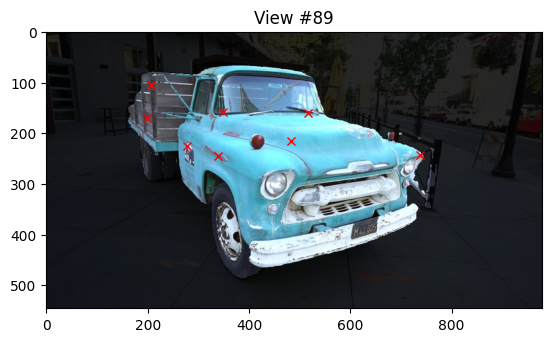

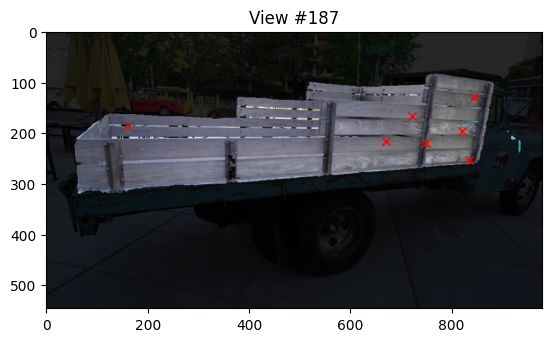

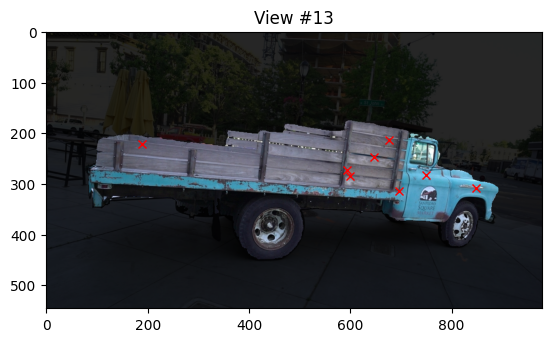

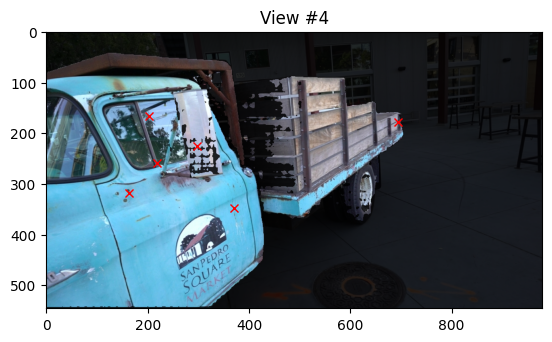

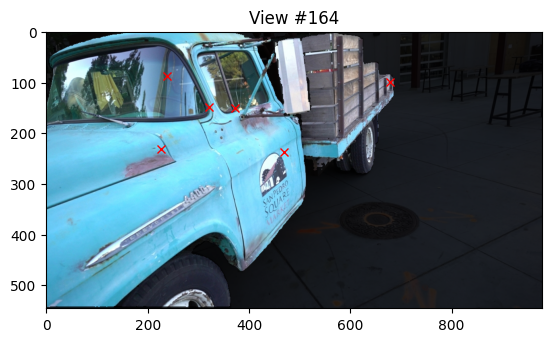

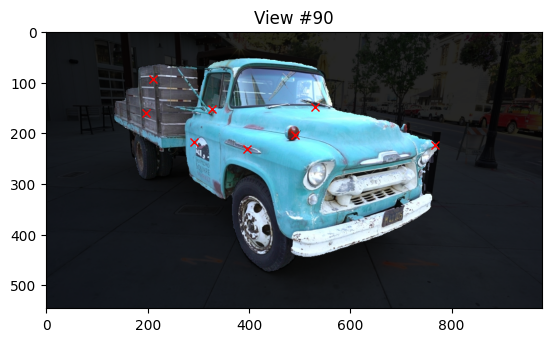

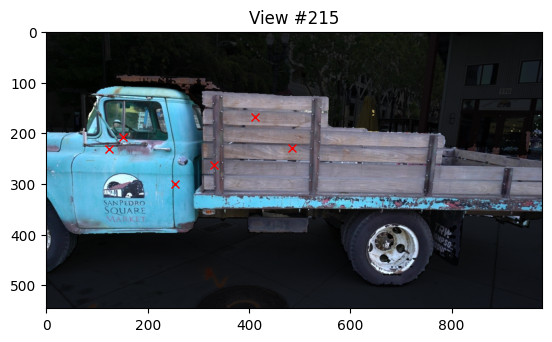

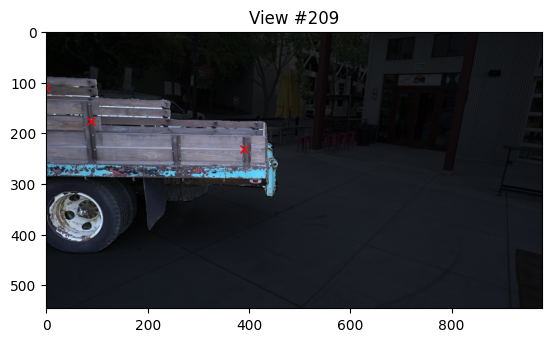

KeyboardInterrupt: 

In [19]:
for view, mask, points in results:
    plt.title(f"View #{view.index}")

    # composites mask with original image, showing faint masked areas
    plt.imshow(np.round(np.clip(mask[:,:,np.newaxis], 0.15, 1, dtype=float) * view.image).astype(int)) 
    plt.plot(points[:,0], points[:,1], 'rx')
    plt.show()

# 3. Majority Voting 

In [6]:
from util.voting import make_filter_matrix, majority_voting

### Create L Matrix 

In [7]:
num_views = len(results) 
num_points = pcd_array.shape[0]

L = make_filter_matrix(results, pcd_array, num_views, num_points)  
print(L) 

tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


### Perform Majority Voting 

In [8]:
segmented_gaussian_mask = majority_voting(L) 

In [9]:
segmented_pcd_array = pcd_array[segmented_gaussian_mask, :] 

In [10]:
segmented_pcd_array

tensor([[-0.2395, -0.2551,  1.3519],
        [-0.9557,  0.3545, -0.2070],
        [-0.5927,  0.2837, -0.0691],
        ...,
        [-0.3108,  0.2783,  0.4586],
        [-0.3086,  0.2989,  0.4473],
        [-0.2978,  0.3362,  0.2431]], dtype=torch.float64)

### Create new ply for segmented gaussians

In [11]:
from util.segment import create_segmented_ply 

create_segmented_ply(pcd, segmented_pcd_array, segmented_gaussian_mask, 'multiView_Text_random.ply')

# Quantitative Results 

In [14]:
DEST_DIR = '../renders' 

from PIL import Image
import numpy as np  
import os 

iou = 0.0 
accuracy = 0.0
count = 0

for filename in os.listdir(os.path.join(DEST_DIR, 'gt')):  

    count += 1 

    gt_file = os.path.join(DEST_DIR, 'gt', filename) 
    rend_file = os.path.join(DEST_DIR, 'renders', filename)

    # Load images
    gt_image = np.asarray(Image.open(gt_file).convert('L'))  # Convert to grayscale
    pred_image = np.asarray(Image.open(rend_file).convert('L'))  # Convert to grayscale 

    # Pad to match pred_image and gt_image 
    pad = np.zeros((pred_image.shape[0], 1))   
    pred_image = np.hstack((pad, pred_image)) 

    # Threshold images to get binary masks, assuming non-black (non-zero) pixels are foreground
    gt_mask = np.array(gt_image) > 0
    pred_mask = np.array(pred_image) > 0

    # Calculate intersection and union
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)

    # Calculate IoU
    iou += intersection.sum() / union.sum()

    # Calculate pixel accuracy
    accuracy += np.mean(gt_mask == pred_mask)  


iou /= count 
accuracy /= count 

print(f'IoU: {iou:.4f}')
print(f'Accuracy: {accuracy:.4f}')

IoU: 0.9243
Accuracy: 0.9749
